<a href="https://colab.research.google.com/github/matteopastore024-dot/Insurance-project/blob/main/Compound_Dist_Approx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import pareto
from scipy.optimize import root_scalar

### In questo Notebook applicherò alcune tecniche di approssiamzione della compund distrubution di un portafoglio di perdite Assicurazione auto per la responsabilità civile (Motor Third-Party Liability, MTPL) trovato in CASdataset. L'idea è vedere la qualità delle approssimazioni. Il dataset è suddiviso in "Small Claim" per le perdite inferiori a 2*10^6 euro e "Large Claim" per le perdite superiori. Non si sono utilizzarte tecniche legate all'EVT per selezionare l'attachment point. Fonte: Wuthrich, Mario V. "Non-life insurance: mathematics & statistics." Available at SSRN 2319328 (2024).


In [5]:
Dati = pd.read_csv("claimloss.csv", sep=";")
Yi = Dati["UltimateCost"]
Yi_small = Yi.loc[Yi < 2* 10**6]

###Costruzione della distribuzione Empirica della total Loss Distribution per gli Small Claims ipotizzando che sia generata da una poisson con parametro $λv=100$


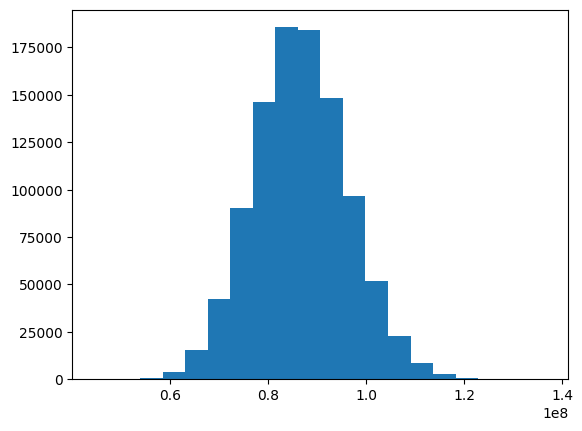

In [7]:
lambda_v = 100
np.random.seed(42)
n = 1000000
S = np.zeros(shape=(n,1))
for i in range(n):
    #Step 1 estraggo da una poisson con parametro lambda_v
    N = np.random.poisson(lambda_v)
    #Step 2 estraggo dalla distribuzione empirica
    Si = np.random.choice(Yi_small,replace=True, size=N)
    S[i] = np.sum(Si)

plt.hist(S, bins = 20)
plt.show()

###Costruzione della funzione di ripartizione Empirica

/tmp/ipython-input-2304541626.py:14: RuntimeWarning: invalid value encountered in log
  axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1 )


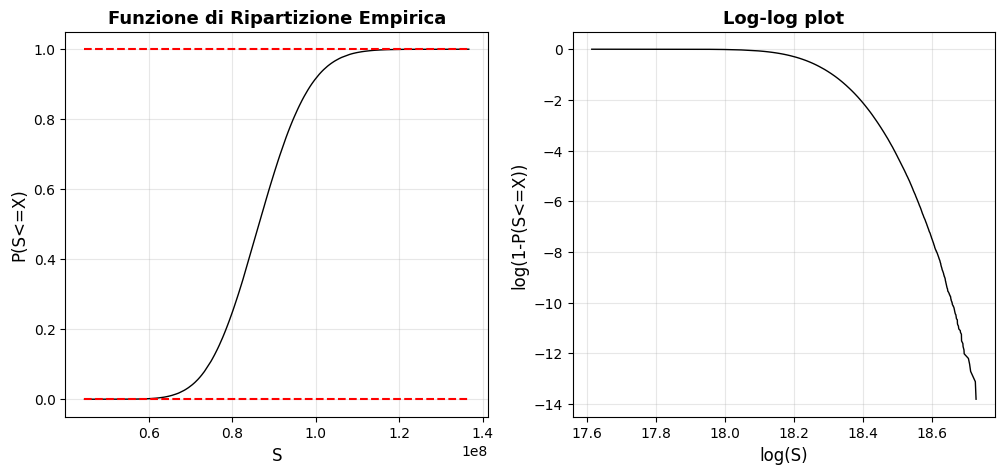

In [8]:
supporto_S = np.sort(S, axis=0)
G = np.cumsum(np.array([1/n for i in range(n)]))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(supporto_S, G, color="black", linewidth=1)
axes[0].set_title("Funzione di Ripartizione Empirica", fontsize=13, weight='bold')
axes[0].set_xlabel("S", fontsize=12)
axes[0].set_ylabel("P(S<=X)", fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].hlines(y=0, xmin=np.min(S, axis=0), xmax=np.max(S,axis=0), color="red",linestyles="dashed")
axes[0].hlines(y=1, xmin=np.min(S, axis=0), xmax=np.max(S,axis=0), color="red",linestyles="dashed")

axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1 )
axes[1].set_title("Log-log plot", fontsize=13, weight='bold')
axes[1].set_xlabel("log(S)", fontsize=12)
axes[1].set_ylabel("log(1-P(S<=X))", fontsize=12)
axes[1].grid(alpha=0.3)
plt.show()

### Approssimazione utilizzando il TLC. sapendo che $S = \sum_{i=1}^{N} Y_i$ e con N distribuito come una poisson con parametro $λ v$ e gli $Y_i$ IID; utilizzando il disjoint decomposition theorem è possibile riscrivere $S = \sum_{l=1}^{v}\sum_{1}^{N_l} Y_i =\sum_{l=1}^{v}S_l$. A questo applicando il TLC si ottiene: $$P[S\leq x] ≈ ϕ\left(\frac{x - λvE[Y_i]}{\sqrt{λvE[Y_i^2]}}\right) $$

/tmp/ipython-input-3659233633.py:16: RuntimeWarning: invalid value encountered in log
  axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")


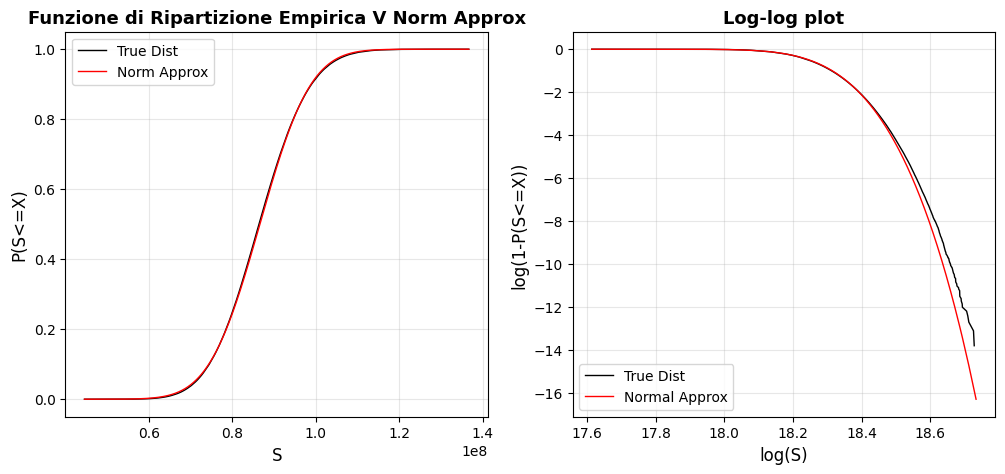

In [9]:
#approssimazione utilizando il teorema del Limite centrale (si ipotizza di conoscere lambda_V perchè col presente dataset non è possibile stimarla)
#l'approssimazione è applicata agli small claim
mu = lambda_v * np.mean(Yi_small)
sigma = np.sqrt(lambda_v * np.mean(Yi_small**2))
G_norm = norm.cdf(supporto_S,loc = mu, scale = sigma)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(supporto_S, G, color="black", linewidth=1,label = "True Dist")
axes[0].plot(supporto_S, G_norm, color= "red", linewidth=1,label = "Norm Approx")
axes[0].set_title("Funzione di Ripartizione Empirica V Norm Approx", fontsize=13, weight='bold')
axes[0].set_xlabel("S", fontsize=12)
axes[0].set_ylabel("P(S<=X)", fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")
axes[1].plot(np.log(supporto_S), np.log(1-G_norm),color="red", linewidth=1 , label = "Normal Approx")
axes[1].set_title("Log-log plot", fontsize=13, weight='bold')
axes[1].set_xlabel("log(S)", fontsize=12)
axes[1].set_ylabel("log(1-P(S<=X))", fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.show(block = True)


### Approssimazione con Translated Gamma X = l + Z con Z avente distribuzione $Γ(γ,c)$. I parametri sono stimatri utilizzando il metodo dei momenti usando la media, la varianza la skewness di S

/tmp/ipython-input-3300032206.py:17: RuntimeWarning: invalid value encountered in log
  axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")


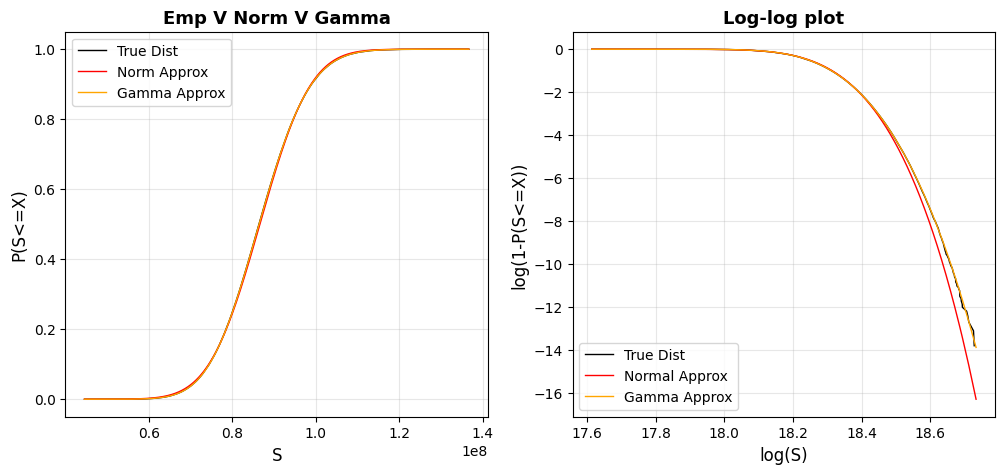

In [10]:
#Approssimazione con translated gamma l+gamma(c,delta) metodo dei momenti per stima dei parametri
l = lambda_v*(np.mean(Yi_small)-2*np.mean(Yi_small**2)**2 /np.mean(Yi_small**3) )
delta = (lambda_v * 4 * np.mean(Yi_small**2)**3)/np.mean(Yi_small**3)**2
c = 2*np.mean(Yi_small**2)/np.mean(Yi_small**3)
G_translated_gamma = gamma.cdf(supporto_S-l,a =delta,scale = 1/c)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(supporto_S, G, color="black", linewidth=1,label = "True Dist")
axes[0].plot(supporto_S, G_norm, color= "red", linewidth=1,label = "Norm Approx")
axes[0].plot(supporto_S, G_translated_gamma, color= "orange", linewidth=1,label = "Gamma Approx")
axes[0].set_title("Emp V Norm V Gamma", fontsize=13, weight='bold')
axes[0].set_xlabel("S", fontsize=12)
axes[0].set_ylabel("P(S<=X)", fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")
axes[1].plot(np.log(supporto_S), np.log(1-G_norm),color="red", linewidth=1 , label = "Normal Approx")
axes[1].plot(np.log(supporto_S), np.log(1-G_translated_gamma),color="orange", linewidth=1 , label = "Gamma Approx")
axes[1].set_title("Log-log plot", fontsize=13, weight='bold')
axes[1].set_xlabel("log(S)", fontsize=12)
axes[1].set_ylabel("log(1-P(S<=X))", fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.show()

### Approssimazione con Translated Lognormal X = l + Z con Z avente distribuzione $LN(μ,σ^2)$. I parametri sono stimatri utilizzando il metodo dei momenti usando la media, la varianza la skewness di S

/tmp/ipython-input-1246904053.py:26: RuntimeWarning: invalid value encountered in log
  axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")


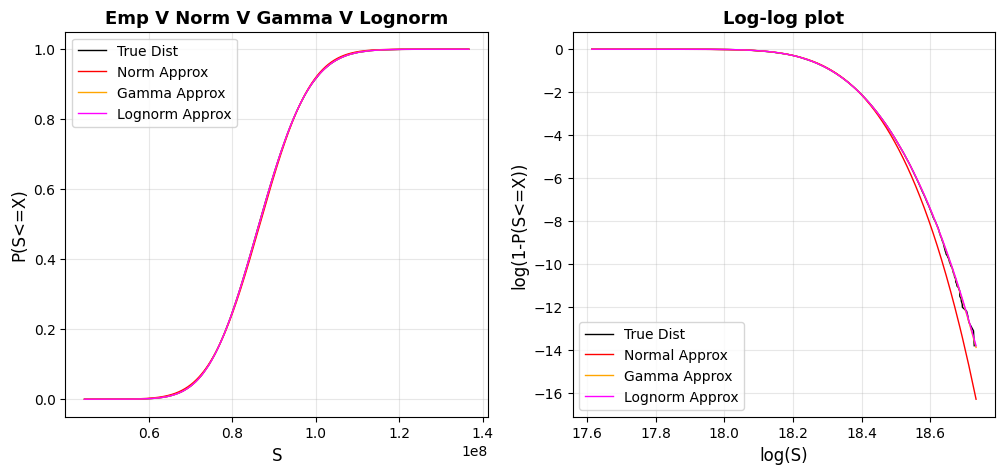

In [11]:
def objective(x):
    num = np.mean(Yi_small**3)
    den = np.sqrt(lambda_v) * (np.mean(Yi_small**2))**(3/2)
    term = (np.exp(x) + 2) * np.sqrt(np.exp(x) - 1)
    return num/den -term
sol = root_scalar(objective, x0=0.001,method='newton')
sigma_squared_lognorm =sol.root

mu_lognorm = 1/2 * np.log(lambda_v * np.mean(Yi_small**2)/(np.exp(sigma_squared_lognorm) * (np.exp(sigma_squared_lognorm)-1)))
k_lognorm = lambda_v * np.mean(Yi_small) -np.exp(mu_lognorm + sigma_squared_lognorm/2)
x = supporto_S - k_lognorm
z = (np.log(x) - mu_lognorm) / np.sqrt(sigma_squared_lognorm)
G_translated_lognorm = norm.cdf(z)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(supporto_S, G, color="black", linewidth=1,label = "True Dist")
axes[0].plot(supporto_S, G_norm, color= "red", linewidth=1,label = "Norm Approx")
axes[0].plot(supporto_S, G_translated_gamma, color= "orange", linewidth=1,label = "Gamma Approx")
axes[0].plot(supporto_S, G_translated_lognorm, color= "magenta", linewidth=1,label = "Lognorm Approx")
axes[0].set_title("Emp V Norm V Gamma V Lognorm", fontsize=13, weight='bold')
axes[0].set_xlabel("S", fontsize=12)
axes[0].set_ylabel("P(S<=X)", fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")
axes[1].plot(np.log(supporto_S), np.log(1-G_norm),color="red", linewidth=1 , label = "Normal Approx")
axes[1].plot(np.log(supporto_S), np.log(1-G_translated_gamma),color="orange", linewidth=1 , label = "Gamma Approx")
axes[1].plot(np.log(supporto_S), np.log(1-G_translated_lognorm),color="magenta", linewidth=1 , label = "Lognorm Approx")
axes[1].set_title("Log-log plot", fontsize=13, weight='bold')
axes[1].set_xlabel("log(S)", fontsize=12)
axes[1].set_ylabel("log(1-P(S<=X))", fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.show()

### Edegeworth Approximation con solo termine di skewness: $$P[S\leq x] ≈ Φ(z) - a_3 Φ^{(3)}(z)$$ con Z ottenuta da $Z=\frac{S-λvE[Y_i]}{\sqrt{λvE[Y_i^2]}}$

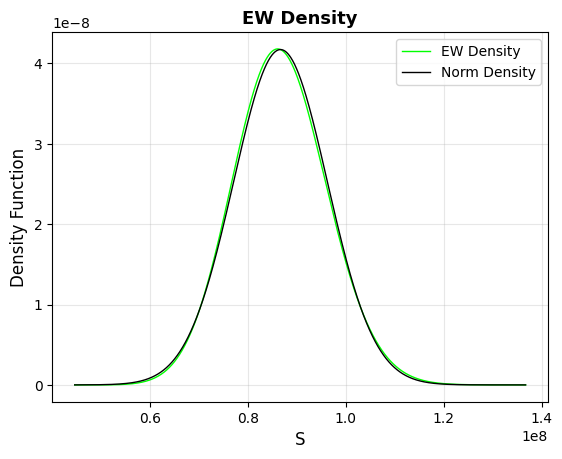

/tmp/ipython-input-1991065701.py:31: RuntimeWarning: invalid value encountered in log
  axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


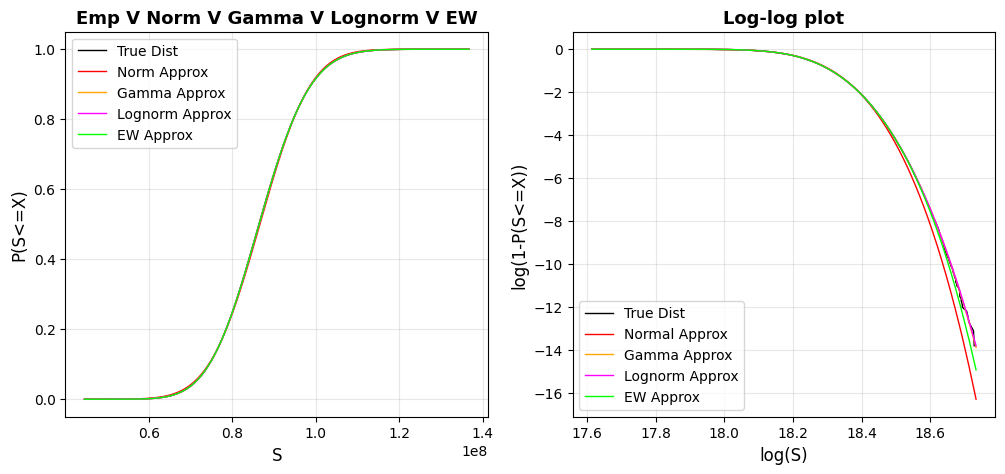

In [12]:
##############hedgeworth approximation###############################
Z = (supporto_S - lambda_v*np.mean(Yi_small))/np.sqrt(lambda_v*np.mean(Yi_small**2))
a3 = (np.mean((supporto_S - lambda_v*np.mean(Yi_small))**3/np.sqrt(lambda_v*np.mean(Yi_small**2))**3) )/math.factorial(3)
EW = norm.cdf(x=Z,loc=0,scale=1) - a3 * norm.pdf(Z,loc=0,scale=1) * (-1 + Z**2)
EW_density = norm.pdf(Z,loc=0,scale=1)*(1-3*a3*Z + a3*Z**3)
EW_density_S= EW_density * 1/np.sqrt(lambda_v*np.mean(Yi_small**2))


fig, ax = plt.subplots()
ax.plot(supporto_S, EW_density_S, linewidth=1, alpha=1, color="#00FF00", label="EW Density")
ax.plot(supporto_S, norm.pdf(Z,loc=0,scale=1)* 1/np.sqrt(lambda_v*np.mean(Yi_small**2)), linewidth=1, alpha=1, color="black", label="Norm Density")
ax.set_title("EW Density", fontsize=13, weight='bold')
ax.set_xlabel("S", fontsize=12)
ax.set_ylabel("Density Function", fontsize=12)
ax.grid(alpha=0.3)
ax.legend()
plt.show(block =True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(supporto_S, G, color="black", linewidth=1,label = "True Dist")
axes[0].plot(supporto_S, G_norm, color= "red", linewidth=1,label = "Norm Approx")
axes[0].plot(supporto_S, G_translated_gamma, color= "orange", linewidth=1,label = "Gamma Approx")
axes[0].plot(supporto_S, G_translated_lognorm, color= "magenta", linewidth=1,label = "Lognorm Approx")
axes[0].plot(supporto_S, EW, color= "#00FF00", linewidth=1,label = "EW Approx")
axes[0].set_title("Emp V Norm V Gamma V Lognorm V EW", fontsize=13, weight='bold')
axes[0].set_xlabel("S", fontsize=12)
axes[0].set_ylabel("P(S<=X)", fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(np.log(supporto_S), np.log(1-G),color="black", linewidth=1,label = "True Dist")
axes[1].plot(np.log(supporto_S), np.log(1-G_norm),color="red", linewidth=1 , label = "Normal Approx")
axes[1].plot(np.log(supporto_S), np.log(1-G_translated_gamma),color="orange", linewidth=1 , label = "Gamma Approx")
axes[1].plot(np.log(supporto_S), np.log(1-G_translated_lognorm),color="magenta", linewidth=1 , label = "Lognorm Approx")
axes[1].plot(np.log(supporto_S), np.log(1-EW),color="#00FF00", linewidth=1 , label = "EW Approx")
axes[1].set_title("Log-log plot", fontsize=13, weight='bold')
axes[1].set_xlabel("log(S)", fontsize=12)
axes[1].set_ylabel("log(1-P(S<=X))", fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.show()

### Come prima forma di controllo si utilizza il Kolmogorov Smirnov test a livello di confidenza del 5% (1.36 come valore critico della statistica). l'idea è controllare che distribuzione ha un KS più basso. Tutto ciò tenendo a mente le limitazioni del test legate soprattutto alle code della distribuzione.

In [13]:
def Kolmogorov_Smirnov_test(supporto, true_dist, H0_dist):
    KS_stat = np.max(np.abs(true_dist - H0_dist) )
    if KS_stat >= 1.36 * len(supporto)**(-0.5):
       print(f"Il Kolmogorv-Smirnov test rifiuta l'ipotesi Nulla al 5% con KS:{KS_stat} >= {1.36 * len(supporto)**(-0.5)}")
    else:
       print(f"Il Kolmogorv-Smirnov test NON rifiuta l'ipotesi Nulla al 5% con KS:{KS_stat} < {1.36 * len(supporto)**(-0.5)}")
    return KS_stat

ks_norm = Kolmogorov_Smirnov_test(supporto_S,G,G_norm[:,0])
ks_tgamma = Kolmogorov_Smirnov_test(supporto_S,G,G_translated_gamma[:,0])
ks_tlognorm = Kolmogorov_Smirnov_test(supporto_S,G,G_translated_lognorm[:,0])
ks_EW = Kolmogorov_Smirnov_test(supporto_S,G,EW[:,0])

print(f"Kolmogorv-Smirnov Test Normale:{ks_norm}")
print(f"Kolmogorv-Smirnov Test Translated Gamma:{ks_tgamma}")
print(f"Kolmogorv-Smirnov Test Translated Lognormal:{ks_tlognorm}")
print(f"Kolmogorv-Smirnov Test Edgeworth Approx:{ks_EW}")

Il Kolmogorv-Smirnov test rifiuta l'ipotesi Nulla al 5% con KS:0.009359759397114031 >= 0.00136
Il Kolmogorv-Smirnov test NON rifiuta l'ipotesi Nulla al 5% con KS:0.0010139543444345755 < 0.00136
Il Kolmogorv-Smirnov test NON rifiuta l'ipotesi Nulla al 5% con KS:0.0010376852671701298 < 0.00136
Il Kolmogorv-Smirnov test NON rifiuta l'ipotesi Nulla al 5% con KS:0.0012441239572713036 < 0.00136
Kolmogorv-Smirnov Test Normale:0.009359759397114031
Kolmogorv-Smirnov Test Translated Gamma:0.0010139543444345755
Kolmogorv-Smirnov Test Translated Lognormal:0.0010376852671701298
Kolmogorv-Smirnov Test Edgeworth Approx:0.0012441239572713036


###In questa sezione si applica il panjer algorithm ad una distribuzione teorica. In questo algoritmo si assume che anche la distribuzione di $Y_i$ sia discreta. Per ottenerla si parte da una Parerto con attachment point $θ=50000$ e $α=2.5$. Il parametro $λv = 3.9$ rigurada la poisson. Per i riferimenti teorici si rimanda a: Wuthrich, Mario V. "Non-life insurance: mathematics & statistics" pag.116 (sez 4.2).

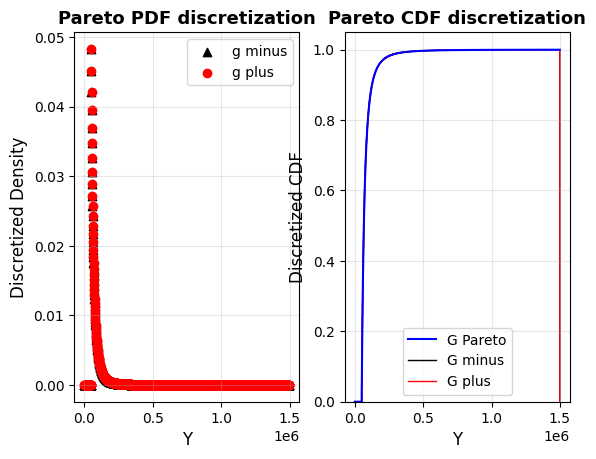

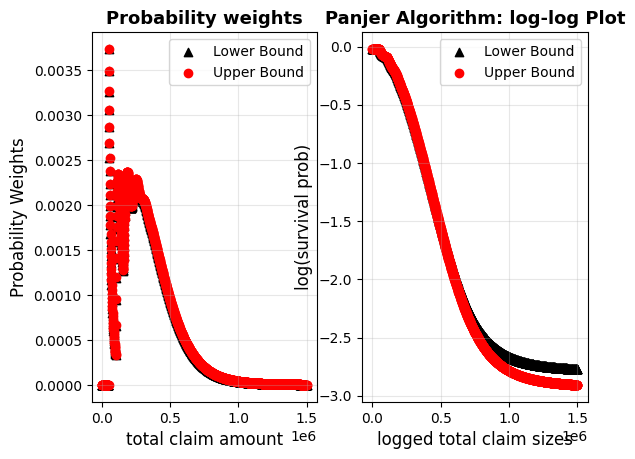

In [15]:
#applcazione del panjer algorithm a claim sizes con distribuzione pareto per la modellazione della parte large claim
theta = 50000
alpha = 2.5
lambda_v_big = 3.9
d = 1000
kmax = 150*10
k = np.arange(kmax)
support = (k)*d
#discretizzazione della pareto associata
g_minus = []
g_plus = [0]

for i in range(len(support)-1):
    if support[i] >= theta:
        value = (support[i]/theta)**(-alpha) - (support[i+1]/theta)**(-alpha)
    else:
        value = .0
    g_minus.append(value)
    g_plus.append(value)

g_minus = np.array(g_minus)
g_plus = np.array(g_plus)
G_minus = np.cumsum(g_minus)
G_plus = np.cumsum(g_plus)
G_pareto = np.zeros_like(support, dtype=float)
G_pareto[support>theta] = 1- (support[support>theta]/theta)**(-alpha)

fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(support[0:-1],g_minus, marker="^",c="black", linewidths=1, label = "g minus")
ax[0].scatter(support[0:-1],g_plus[0:-1], marker="o",c="red", linewidths=1, label = "g plus")
ax[0].set_title("Pareto PDF discretization", fontsize=13, weight='bold')
ax[0].set_xlabel("Y", fontsize=12)
ax[0].set_ylabel("Discretized Density", fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(support,G_pareto, label = "G Pareto", color = "blue")
ax[1].stairs(values=G_minus,edges=support, color = "black", label = "G minus")
ax[1].stairs(values=G_plus[0:-1],edges=support, color = "red", label = "G plus")
ax[1].set_title("Pareto CDF discretization", fontsize=13, weight='bold')
ax[1].set_xlabel("Y", fontsize=12)
ax[1].set_ylabel("Discretized CDF", fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()
fr_plus = [np.exp(-lambda_v_big)]
fr_minus = [np.exp(-lambda_v_big)]
g_plus_flipped = np.flip(g_plus)
g_minus_flipped = np.flip(g_minus)
k_flipped = np.flip(k)
for i in range(len(k)-1):
    fr_plus.append(lambda_v_big/(i+1) * np.sum(k_flipped[(-i-1):-1]*g_plus_flipped[(-i-1):-1] * np.array(fr_plus[0:i])))
    fr_minus.append(lambda_v_big/(i+1) * np.sum(k_flipped[(-i-1):-1] * g_minus_flipped[(-i-1):-1] * np.array(fr_plus[0:i])))

fr_minus = np.array(fr_minus)
fr_plus = np.array(fr_plus)
Gfr_minus = np.cumsum(fr_minus)
Gfr_plus = np.cumsum(fr_plus)

fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(support[1:],fr_minus[1:], marker="^",c="black", linewidths=1, label = "Lower Bound")
ax[0].scatter(support[1:],fr_plus[1:], marker="o",c="red", linewidths=1, label = "Upper Bound")
ax[0].set_title("Probability weights", fontsize=13, weight='bold')
ax[0].set_xlabel("total claim amount", fontsize=12)
ax[0].set_ylabel("Probability Weights", fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].scatter(support,np.log(1-Gfr_minus), marker="^",c="black", linewidths=1, label = "Lower Bound")
ax[1].scatter(support,np.log(1-Gfr_plus), marker="o",c="red", linewidths=1, label = "Upper Bound")
ax[1].set_title("Panjer Algorithm: log-log Plot", fontsize=13, weight='bold')
ax[1].set_xlabel("logged total claim sizes", fontsize=12)
ax[1].set_ylabel("log(survival prob)", fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()


### In questa sezione si applica quanto visto prima ai large claim del dataset. L'attachment point era stato fissato a $θ = 2*10^6$euro mentre alpha viene stimato col metodo della massima verosimiglianza. Il reso della procedura è identico

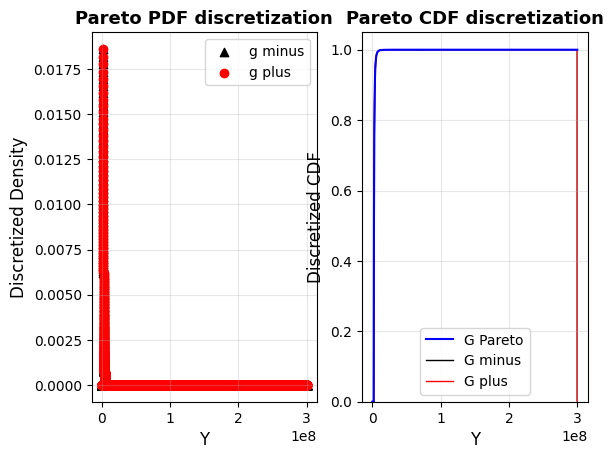

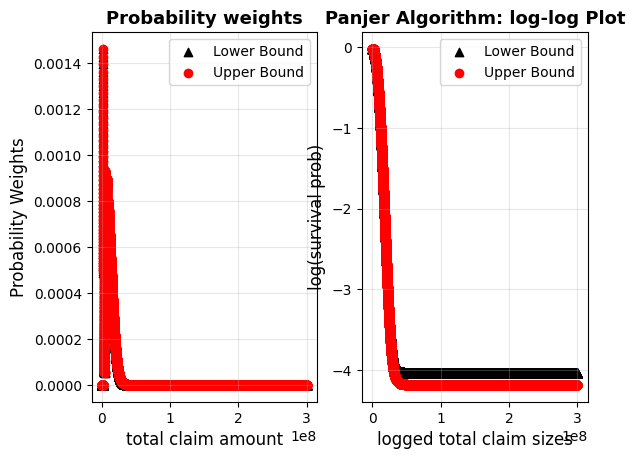

In [16]:
########################################################################################################################
########################### Applicazione ai large Claim ################################################################
########################################################################################################################
lambda_vLC = 3.9 #sempre da assumere perchè non si hanno i dati per stimarlo.
thetaLC = 2*10**6
Yi_large = Yi[Yi>thetaLC]
alphaLC = (np.mean(np.log(Yi_large))-np.log(thetaLC))**(-1) #stimatore MV per alpha LC fissato l'attachment point

d = 10000
kmax = 300*100
k = np.arange(kmax)
support = (k)*d
#discretizzazione della pareto associata
g_minusLC = []
g_plusLC = [0]

for i in range(len(support)-1):
    if support[i] >= thetaLC:
        value = (support[i]/thetaLC)**(-alphaLC) - (support[i+1]/thetaLC)**(-alphaLC)
    else:
        value = .0
    g_minusLC.append(value)
    g_plusLC.append(value)

g_minusLC = np.array(g_minusLC)
g_plusLC = np.array(g_plusLC)
G_minusLC = np.cumsum(g_minusLC)
G_plusLC = np.cumsum(g_plusLC)
G_pareto = np.zeros_like(support, dtype=float)
G_pareto[support>thetaLC] = 1- (support[support>thetaLC]/thetaLC)**(-alphaLC)

fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(support[0:-1],g_minusLC, marker="^",c="black", linewidths=1, label = "g minus")
ax[0].scatter(support[0:-1],g_plusLC[0:-1], marker="o",c="red", linewidths=1, label = "g plus")
ax[0].set_title("Pareto PDF discretization", fontsize=13, weight='bold')
ax[0].set_xlabel("Y", fontsize=12)
ax[0].set_ylabel("Discretized Density", fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(support,G_pareto, label = "G Pareto", color = "blue")
ax[1].stairs(values=G_minusLC,edges=support, color = "black", label = "G minus")
ax[1].stairs(values=G_plusLC[0:-1],edges=support, color = "red", label = "G plus")
ax[1].set_title("Pareto CDF discretization", fontsize=13, weight='bold')
ax[1].set_xlabel("Y", fontsize=12)
ax[1].set_ylabel("Discretized CDF", fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()
fr_plusLC = [np.exp(-lambda_vLC)]
fr_minusLC = [np.exp(-lambda_vLC)]
g_plusLC_flipped = np.flip(g_plusLC)
g_minusLC_flipped = np.flip(g_minusLC)
k_flipped = np.flip(k)
for i in range(len(k)-1):
    fr_plusLC.append(lambda_vLC/(i+1) * np.sum(k_flipped[(-i-1):-1]*g_plusLC_flipped[(-i-1):-1] * np.array(fr_plusLC[0:i])))
    fr_minusLC.append(lambda_vLC/(i+1) * np.sum(k_flipped[(-i-1):-1] * g_minusLC_flipped[(-i-1):-1] * np.array(fr_plusLC[0:i])))

fr_minusLC = np.array(fr_minusLC)
fr_plusLC = np.array(fr_plusLC)
Gfr_minusLC = np.cumsum(fr_minusLC)
Gfr_plusLC = np.cumsum(fr_plusLC)

fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(support[1:],fr_minusLC[1:], marker="^",c="black", linewidths=1, label = "Lower Bound")
ax[0].scatter(support[1:],fr_plusLC[1:], marker="o",c="red", linewidths=1, label = "Upper Bound")
ax[0].set_title("Probability weights", fontsize=13, weight='bold')
ax[0].set_xlabel("total claim amount", fontsize=12)
ax[0].set_ylabel("Probability Weights", fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].scatter(support,np.log(1-Gfr_minusLC), marker="^",c="black", linewidths=1, label = "Lower Bound")
ax[1].scatter(support,np.log(1-Gfr_plusLC), marker="o",c="red", linewidths=1, label = "Upper Bound")
ax[1].set_title("Panjer Algorithm: log-log Plot", fontsize=13, weight='bold')
ax[1].set_xlabel("logged total claim sizes", fontsize=12)
ax[1].set_ylabel("log(survival prob)", fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

### A questo punto possiamo ricavare la distribuzione completa di $X_{sc}$ + $S_{lc}$. Per $X_{sc}$ si utilizza la Translated Gamma stimata in precedenza. Per Slc si utilizza l'approssiamzione con il pnajer algorithm. Per poter costruire l'upper bound e il lower bound risulta più semplice discretizzare anche la funzione di densità di Xsc. Dopo aver fatto ciò è sufficente risolvere la seguente: $$P[X_{sc} + S_{lc} = rd] = P[S_{lc} = rd - X_{sc}] $$
###$$=E[E[1_{S_{lc} = rd - X_{sc}}|X_{sc} = kd] ]$$
###$$=\sum_{kd\leq rd}^{rd} E[1_{S_{lc} = rd - X_{sc}}|X_{sc} = kd] P[X_{sc}=kd]$$
###$$=\sum_{kd\leq rd}^{rd} P[S_{lc} = rd-kd] P[X_{sc}=kd]$$

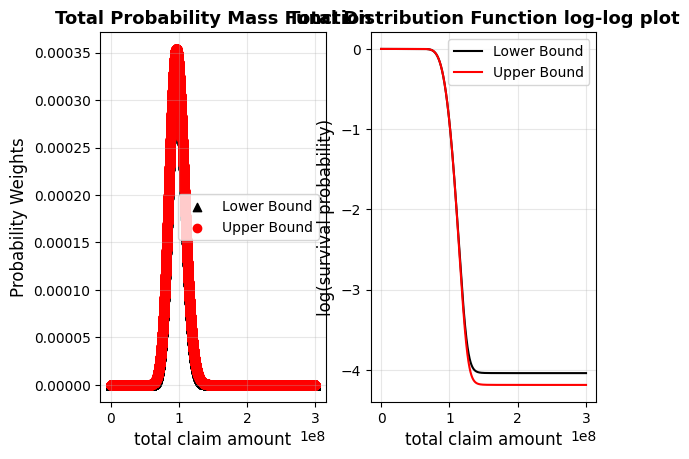

In [17]:
#per Xsc prendo l'approssiamzione con la gamma che sembrava la migliore graficamente.


diff = gamma.cdf(support[1:]-l,a =delta,scale = 1/c) - gamma.cdf(support[:-1]-l,a =delta,scale = 1/c)

fr_plusSC = np.append(np.array(0), diff)
fr_minusSC = diff

final_density_plus = []
final_density_minus = []
fr_plusSC_flipped = np.flip(fr_plusSC)
fr_minusSC_flipped = np.flip(fr_minusSC)

for rd in range(len(support)-1):
    final_density_plus.append(np.sum(fr_plusSC_flipped[-rd-1:] * fr_plusLC[:rd+1]))
    final_density_minus.append(np.sum(fr_minusSC_flipped[-rd - 1:] * fr_minusLC[:rd+1]))

final_density_plus = np.array(final_density_plus)
final_density_minus = np.array(final_density_minus)
G_final_plus = np.cumsum(final_density_plus)
G_final_minus = np.cumsum(final_density_minus)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(support[:-1],final_density_minus, marker="^",c="black", linewidths=1, label = "Lower Bound")
ax[0].scatter(support[:-1],final_density_plus, marker="o",c="red", linewidths=1, label = "Upper Bound")
ax[0].set_title("Total Probability Mass Function", fontsize=13, weight='bold')
ax[0].set_xlabel("total claim amount", fontsize=12)
ax[0].set_ylabel("Probability Weights", fontsize=12)
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(support[:-1], np.log(1-G_final_minus), color = "black", label = "Lower Bound")
ax[1].plot(support[:-1], np.log(1-G_final_plus), color = "red", label = "Upper Bound")
ax[1].set_title("Total Distribution Function log-log plot", fontsize=13, weight='bold')
ax[1].set_xlabel("total claim amount", fontsize=12)
ax[1].set_ylabel("log(survival probability)", fontsize=12)
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show(block = True)
